# LinkedIn's response to Prophet - Silverkite and Greykite

## Setup

In [1]:
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import plotly

from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

## Loading the data

In [2]:
df = DataLoader().load_peyton_manning()
df.head()

,ts,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
# specify dataset information
metadata = MetadataParam(
    time_col="ts",
    value_col="y",
    freq="D"
)
metadata

MetadataParam(anomaly_info=None, date_format=None, freq='D', time_col='ts', train_end_date=None, value_col='y')

## Defining and running the model

In [4]:
# creates forecasts and stores the result
forecaster = Forecaster()  

# specify the config
fcst_congig = ForecastConfig(
    model_template=ModelTemplateEnum.SILVERKITE.name,
    forecast_horizon=365,
    coverage=0.95,
    metadata_param=metadata
)

# run the model
result = forecaster.run_forecast_config(
    df=df,
    config=fcst_congig
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


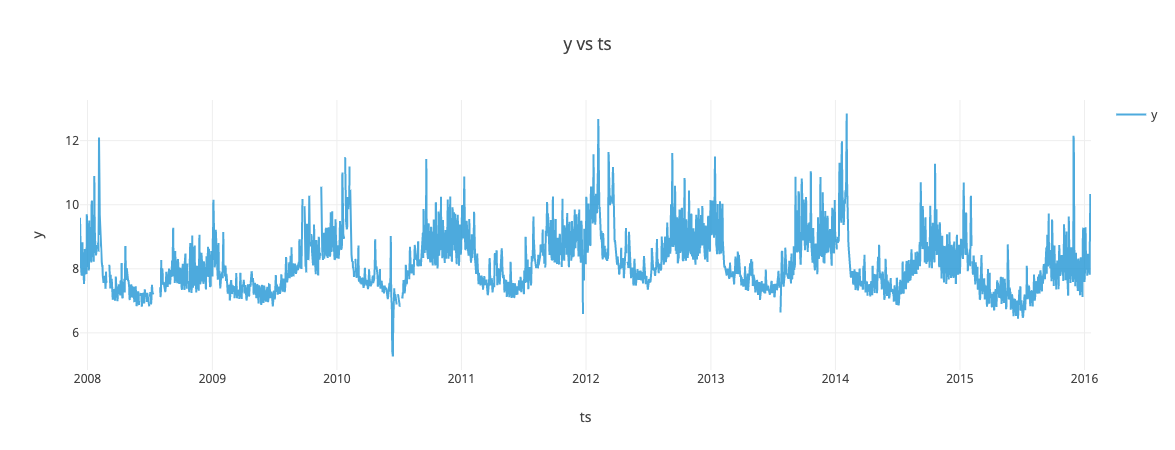

In [5]:
# inspect the data
ts = result.timeseries
fig = ts.plot()
plotly.io.show(fig)

## Cross-validation results

In [6]:
cv_results = summarize_grid_search_results(
    grid_search=result.grid_search,
    decimals=2,
    cv_report_metrics=None, # concise output
    column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"]
)

# transpose to save space in the printed output
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,7.31
split_test_MAPE,"(5.02, 8.53, 8.39)"
mean_train_MAPE,4.2
split_train_MAPE,"(3.82, 4.25, 4.54)"
mean_fit_time,6.09
mean_score_time,0.76


## Results of the houldout test set

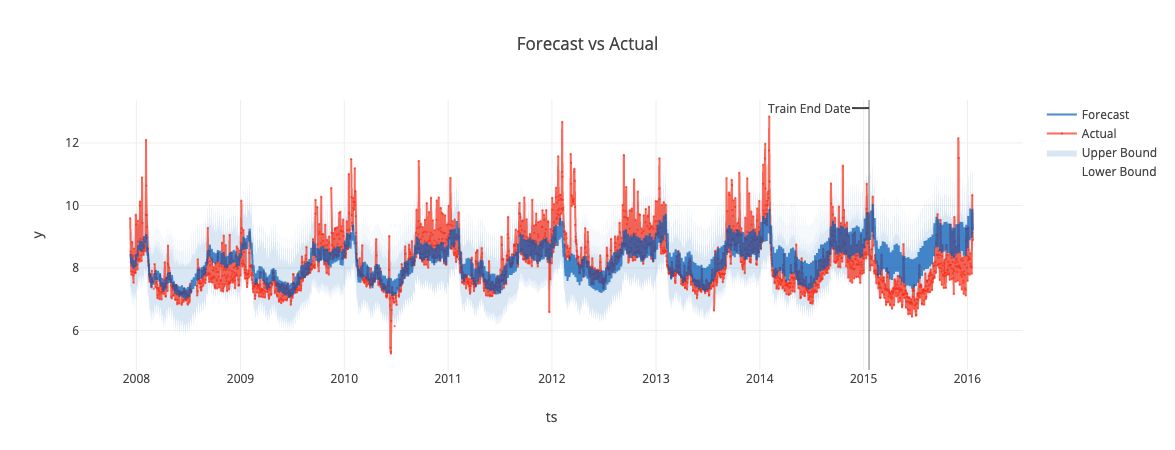

In [7]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [8]:
backtest_eval = defaultdict(list)
for metric, value in backtest.train_evaluation.items():
    backtest_eval[metric].append(value)
    backtest_eval[metric].append(backtest.test_evaluation[metric])
metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
metrics

,train,test
CORR,0.754233,0.756897
R2,0.556228,-0.695154
MSE,0.317248,0.865076
RMSE,0.563247,0.930095
MAE,0.401251,0.856716
MedAE,0.300722,0.840022
MAPE,4.75745,11.3071
MedAPE,3.775,11.2497
sMAPE,2.38715,5.318
Q80,0.200944,0.187063


## Predictions

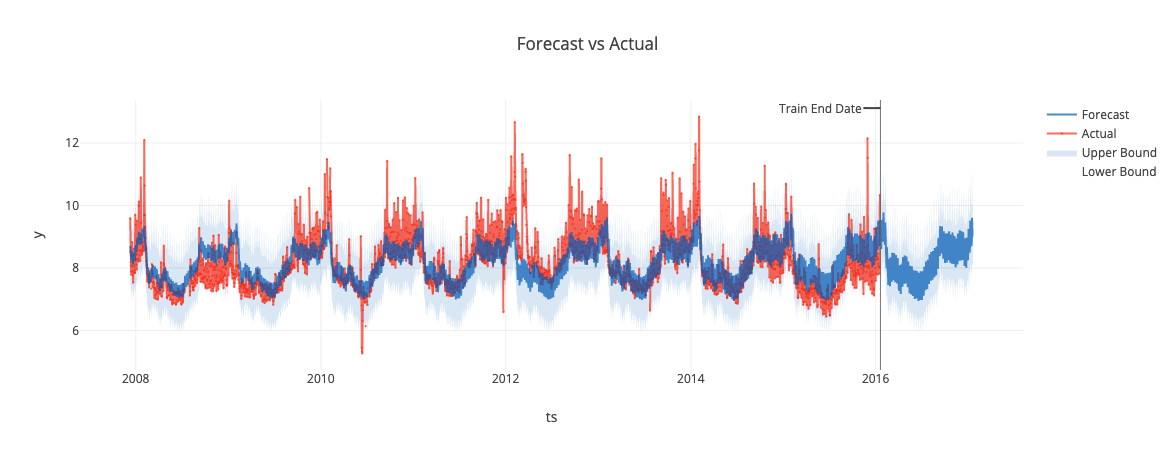

In [9]:
forecast = result.forecast
fig = forecast.plot()
plotly.io.show(fig)

In [10]:
forecast.df.head().round(2)

,ts,actual,forecast,forecast_lower,forecast_upper
0,2007-12-10,9.59,8.71,7.17,10.24
1,2007-12-11,8.52,8.57,7.46,9.68
2,2007-12-12,8.18,8.45,7.49,9.41
3,2007-12-13,8.07,8.38,7.44,9.33
4,2007-12-14,7.89,8.36,7.32,9.40


## Diagnostics

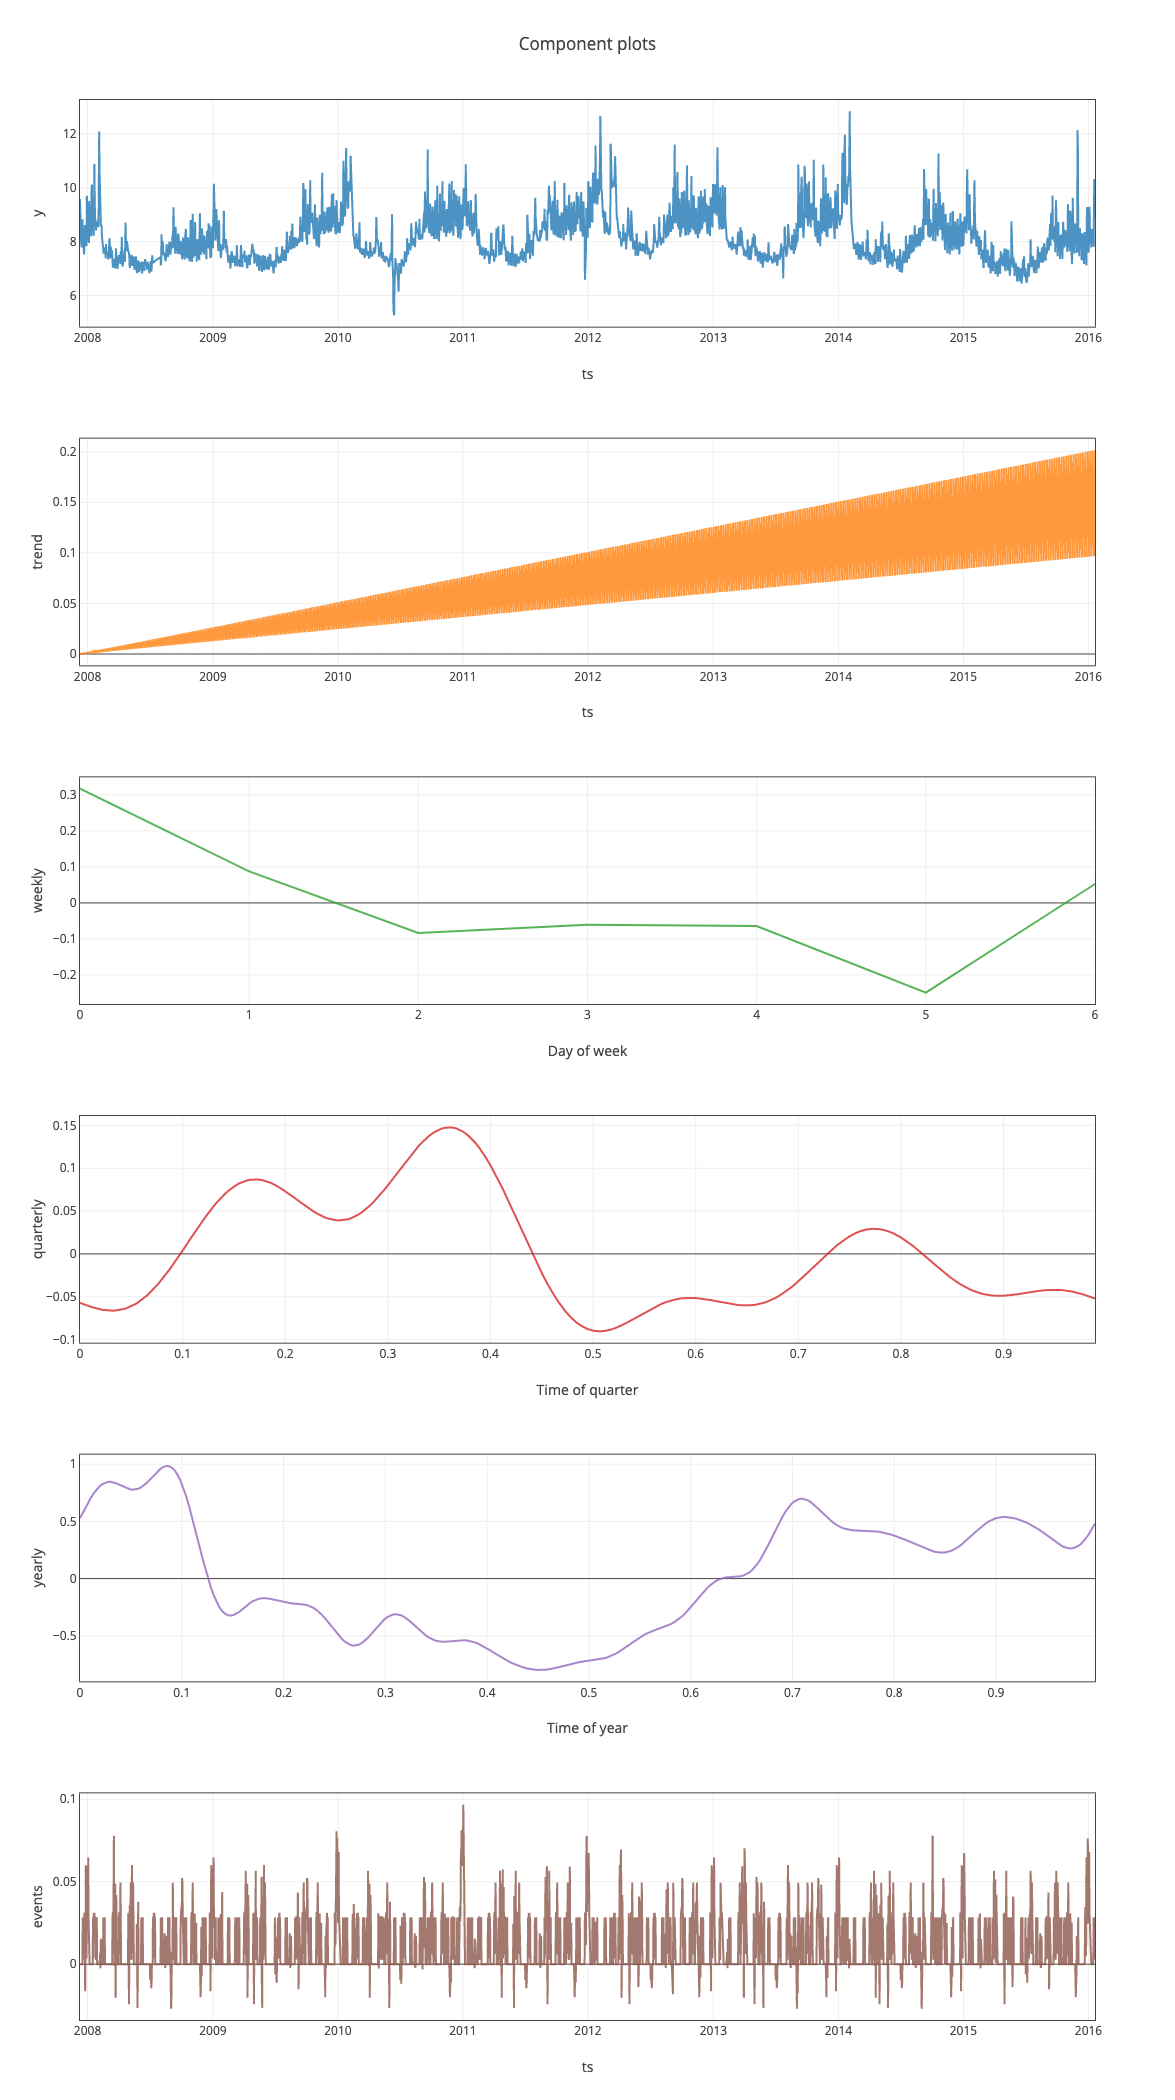

In [11]:
fig = forecast.plot_components()
plotly.io.show(fig)     # fig.show() if you are using "PROPHET" template

In [14]:
summary = result.model[-1].summary()
print(summary)

================================ Model Summary =================================

Number of observations: 2964,   Number of features: 122
Method: Ridge regression
Number of nonzero features: 122
Regularization parameter: 148.5

Residuals:
         Min           1Q       Median           3Q          Max
      -2.342      -0.3604     -0.06554         0.26        3.759

             Pred_col    Estimate  Std. Err Pr(>)_boot sig. code                   95%CI
            Intercept       8.049   0.02104     <2e-16       ***           (8.01, 8.091)
  events_C...New Year    0.007008   0.01936      0.718               (-0.02856, 0.04682)
  events_C...w Year-1    0.002321   0.01507      0.862               (-0.02836, 0.02873)
  events_C...w Year-2    0.002074   0.01659      0.884               (-0.02771, 0.03663)
  events_C...w Year+1   -0.002421   0.01513      0.878                (-0.03211, 0.0284)
  events_C...w Year+2     0.01539   0.01885      0.412               (-0.01743, 0.05475)
 events

## New predictions

In [13]:
# extract the model from the results
model = result.model

# create the future dataframe
future_df = result.timeseries.make_future_dataframe(
    periods=4,
    include_history=False)

# get predictions
model.predict(future_df)

,ts,forecast,forecast_lower,forecast_upper,y_quantile_summary
0,2016-01-21,8.971131,8.023176,9.919087,"(8.023175764425012, 9.919086953794316)"
1,2016-01-22,8.971261,7.930734,10.011789,"(7.930733838005737, 10.011788866680934)"
2,2016-01-23,8.610398,7.565959,9.654837,"(7.565959127781374, 9.654837376620923)"
3,2016-01-24,9.087944,7.794432,10.381456,"(7.794431622702435, 10.3814559235619)"
